# Introduction to Machine Learning

By Rama Vasudevan, CNMS, ORNL

In this notebook we will load some data using SciFiReaders. Then we will perform some basic machine learning tasks.


In [1]:
#Install required packages

!pip install -q sidpy SciFiReaders pycroscopy wget ipympl
!pip install numpy==1.24.4

#After installation, restart the kernel!

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 35.6 MB/s eta 0:00:0

In [3]:
import wget
wget.download(url='https://zenodo.org/record/8190744/files/bto_atomic.dm3?download=1',
              out = 'bto_atomic.dm3')

'bto_atomic.dm3'

In [1]:
colab = True #Set to True if in Google Colab, else set to False
if colab:
    %matplotlib widget
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    %matplotlib notebook
#     %gui qt

In [3]:
#Import the required packages
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sidpy as sid
import SciFiReaders as sr

# Load a STEM image file and plot it

This is an example of a STEM image of a BaTiO<sub>3</sub> thin film taken by Albina Borisevich.


In [4]:
dm3_file = r'bto_atomic.dm3'

dm3_reader = sr.DM3Reader(dm3_file)
data = dm3_reader.read()[0]


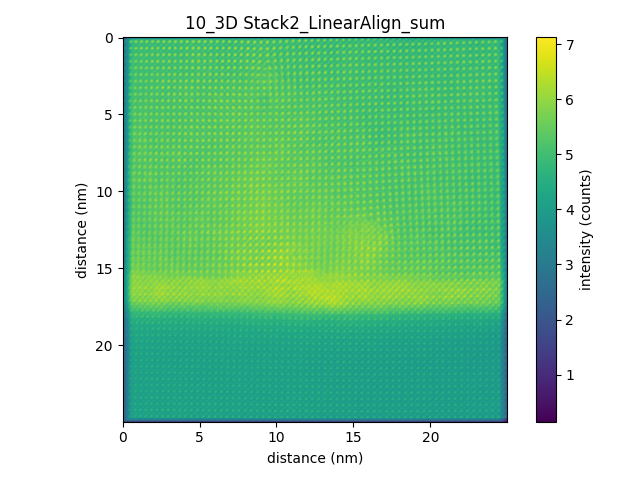

In [5]:
data.plot();

<ipython-input-15-7e6037d809d7>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


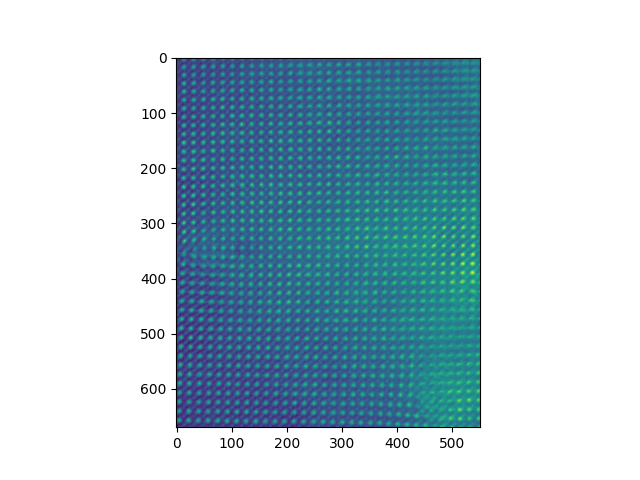

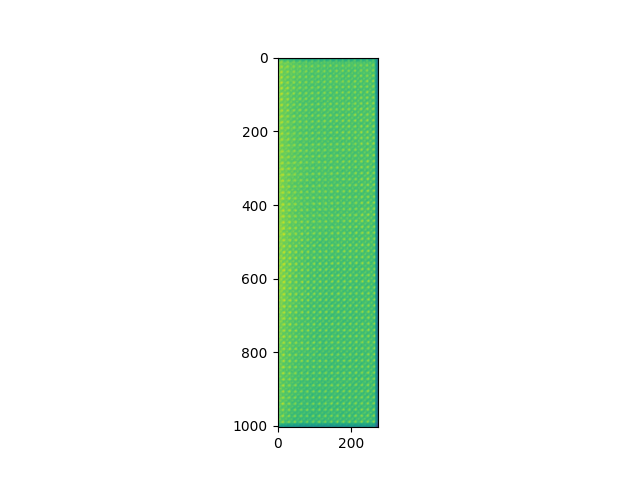

In [15]:
#Let's isolate the film from the substrate
bto_image = data[30:700,50:600]
sto_image = data[10:-10, 750:]

plt.figure()
plt.imshow(bto_image)

plt.figure()
plt.imshow(sto_image)

In [18]:
#We can use make image patches using image windowing in pycroscopy
from pycroscopy.image import ImageWindowing

parms_dict = {}
parms_dict['window_step_x'] = 32
parms_dict['window_step_y'] = 32
parms_dict['window_size_x'] = 32
parms_dict['window_size_y'] = 32
parms_dict['mode'] = 'image'

iw = ImageWindowing(parms_dict)
windows_bto = iw.MakeWindows(bto_image)
windows_sto = iw.MakeWindows(sto_image)

Text(0.5, 0.98, 'STO Image patches')

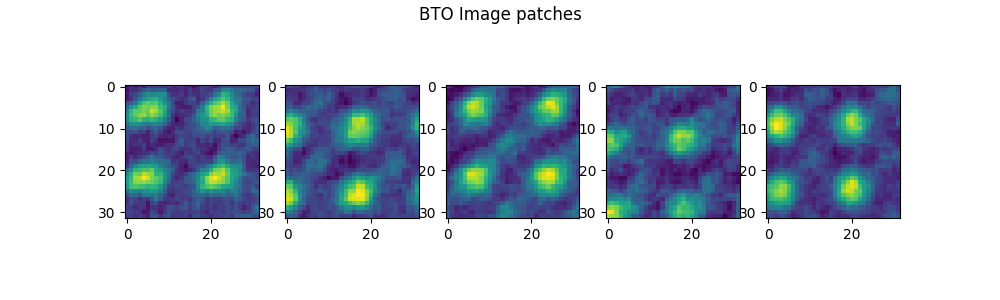

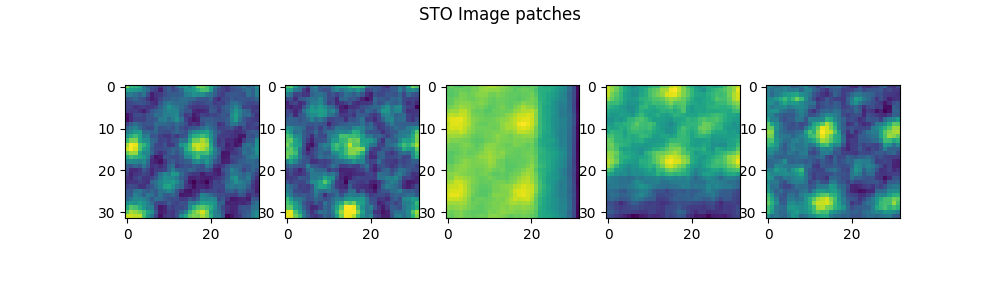

In [20]:
#Let's plot the patches to see what they look like

windows_bto_lin = np.array(windows_bto).reshape(-1, 32,32)
windows_sto_lin = np.array(windows_sto).reshape(-1, 32,32)

#Plot some random windows for bto and sto
rand_plots = 5
fig, axes = plt.subplots(nrows=1, ncols=rand_plots, figsize=(10,3))
rand_nums_bto = np.random.choice(np.arange(windows_bto_lin.shape[0]), rand_plots, replace = False)
for ind, ax in enumerate(axes.flat):
    ax.imshow(windows_bto_lin[rand_nums_bto[ind],:,:])
fig.suptitle('BTO Image patches')

fig2, axes2 = plt.subplots(nrows=1, ncols=rand_plots, figsize=(10,3))
rand_nums_sto = np.random.choice(np.arange(windows_sto_lin.shape[0]), rand_plots, replace = False)
for ind, ax in enumerate(axes2.flat):
    ax.imshow(windows_sto_lin[rand_nums_sto[ind],:,:])
fig2.suptitle('STO Image patches')





It woudl be good to automatically classify which of these image patches come from the film and which comes from the substrate.

We can do this using a classification algorithm and supervised ML....

# 1. Support Vector Machines
=====================================

Support Vector Machines are linear classifiers that are easy to understand. Let's start by simulating some data, and then using the SVM implementation in scikit-learn in order to separate the data into two classes.


Text(0.5, 1.0, 'Toy Problem')

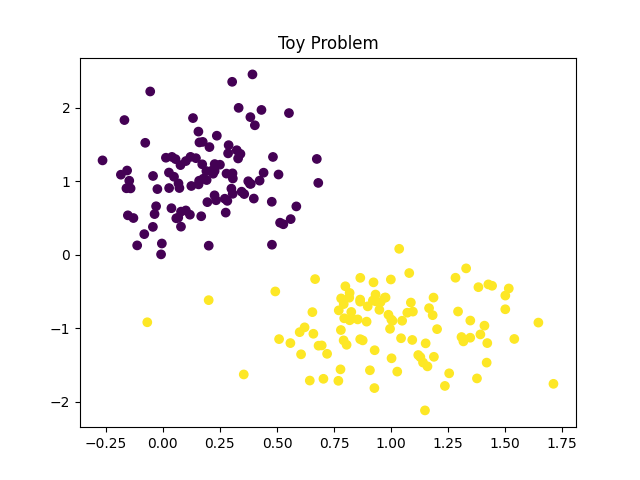

In [21]:
#Generate some random data

X1 = 0.2 + 0.2*np.random.randn(100)
Y1 = 1 + 0.5*np.random.randn(100)

X2 = 1 + 0.3*np.random.randn(100)
Y2 = -1 + 0.4*np.random.randn(100)

class_1 = np.vstack((X1,Y1))
class_2 = np.vstack((X2,Y2))

labels = np.zeros(shape = (class_1.shape[1]+class_2.shape[1]))

#Create a labels vector
labels[:class_1.shape[1]] = 0
labels[class_1.shape[1]:] = 1

all_points = np.hstack((class_1,class_2)) #join all the points together

#Plot it
fig, axes = plt.subplots()
axes.scatter(all_points[0,:], all_points[1,:], c = labels)
axes.set_title('Toy Problem')

In [22]:
#We first need to split the data into a set for training and a set for testing.
#We can do this using the method train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_points.T, labels, test_size=0.25, shuffle = True)

In [23]:
#Let's train an SVM classifier
from sklearn.svm import SVC

C = 1.0 #tradeoff between maximizing the margin vs. mis-classification
        #Making this higher favors smaller margins for reduced mis-classification

svc = SVC(kernel = 'rbf')
#Fit it to the training data
svc.fit(X_train, y_train)

#Now let's test the classifier
y_pred = svc.predict(X_test)
#Score it
score = svc.score(X_test,y_test)
print('Score: ' + str(score))

Score: 1.0


# Plotting the Decision boundary surface

We can plot the decision boundary using the code below. This code is directly taken from the example in the sklean page, i.e. http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html

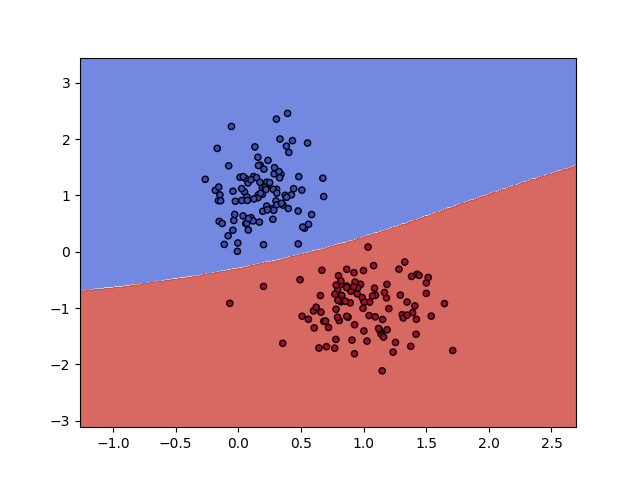

In [24]:

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


xx, yy = make_meshgrid(all_points[0,:], all_points[1,:])

fig, axes = plt.subplots()

plot_contours(axes, svc, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
axes.scatter(all_points[0,:], all_points[1,:], c=labels, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

# Exercise

1. Vary the C parameter and see how the decision boundary surface changes.
2. Play with the kernel parameter, and see what effects this has.
3. (Advanced): See if the SVM can be used as a classifier in the STEM image patches example

In [ ]:
#Let's look at the way to do (3)

